In [31]:
import tensorflow  as tf
import numpy as np 
import zipfile
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import cv2

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

import imutils
from imutils.contours import sort_contours

1/1 [==============================] - 0s 18ms/step
['A', '1', 'A', 'Z', 'A', '3', 'A', '4', 'A', '5', 'A', 'G', 'A', '7']


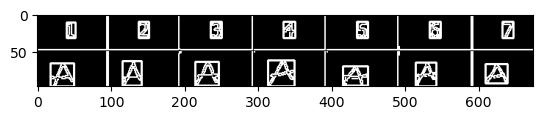

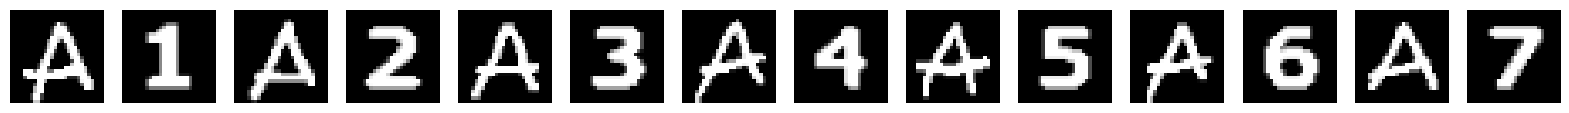

In [45]:
model = tf.keras.models.load_model('./models/second_model.h5')

name_labels = '0123456789'
name_labels += 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
name_labels = [l for l in name_labels]
len(name_labels)

def preprocessing_img(path_img):
    img = cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2GRAY) 
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
    # thresh = cv2.erode(thresh, np.ones((3,3), np.uint8))

    thresh = cv2.Canny(thresh, 40, 150)
    thresh = cv2.dilate(thresh, np.ones((2, 2), np.uint8))
    # thresh = cv2.GaussianBlur(thresh, (5,5), 0)

    return img, thresh

gray, thresh = preprocessing_img(path_img='image.png')


    
def find_contours(img):
    img_copy = img.copy()
    conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    conts = sort_contours(conts, method='left-to-right')[0]

    min_w, max_w = 5, 50
    min_h, max_h = 10, 40 
    n = 5
    letters = []
    conts_2 = []
    for c in conts:
        (x, y, w, h) = cv2.boundingRect(c)
        if (w >= min_w and w < max_w) and (h >= min_h and h < max_h):
            img_p = gray[y-n : y+h+n,   x-n : x+n+w ]
            cv2.rectangle(img_copy, (x,y), (x+w, h+y), (255,100,0),2)
            img_p = cv2.threshold(img_p, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            img_p = cv2.dilate(img_p, np.ones((2,2), np.uint8 ))
            letters.append(img_p)
            conts_2.append(c)
    plt.imshow(img_copy, cmap='gray');
    return letters, conts_2

def img_prediction(img, model, name_labels):
    img = cv2.resize(img, (28,28))
    img = img.astype('float32')/255.0
    img = np.expand_dims(img, axis=-1)
    img = np.reshape(img, (1,28,28,1))

    prediction = model.predict(img)
    prediction = name_labels[np.argmax(prediction)]

    return prediction

letters = find_contours(thresh)[0]

img_predictions = []
for letter in letters:
    img = img_prediction(letter, model, name_labels)
    img_predictions.append(img)

print(img_predictions)

fig, axes = plt.subplots(1, len(letters), figsize=(20,5) )

for i, letter in enumerate(letters):
    letter = cv2.resize(letter, (28,28))
    axes[i].imshow(letter, cmap='gray')

    axes[i].axis('off')

In [42]:

def df_show(num_options, num_questions):
    num_options_list = ['' for i in range(num_options)]
    num_questions_list = [1+i for i in range(num_options)]

    df = {
        'P  R  E  G  U  N  T  A': num_questions_list,
        'R  E  S  P  U  E  S  T  A ': num_options_list
        }
    df = pd.DataFrame(df)
    df = df.transpose()
    df = df.style.set_properties(**{'font-family': 'Tahoma', 'font-size': '14pt'}) \
                        .set_table_styles([{
                            'selector': 'td, th',
                            'props': [('padding', '20px')]
                        }])
    with pd.ExcelWriter('df.xlsx', engine='openpyxl') as df_1:
        df.to_excel(df_1, index=True, header=False)

    return df

df = df_show(num_options= 8, num_questions= 7)
df


,0,1,2,3,4,5,6,7
P R E G U N T A,1,2,3,4,5,6,7,8
R E S P U E S T A,,,,,,,,


In [1]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, Border, Side
from openpyxl.utils.dataframe import dataframe_to_rows

def df_show(num_options, num_questions):
    num_options_list = ['' for _ in range(num_questions)]
    num_questions_list = [1 + i for i in range(num_questions)]

    df = {
        'P  R  E  G  U  N  T  A': num_questions_list,
        'R  E  S  P  U  E  S  T  A ': num_options_list
    }
    df = pd.DataFrame(df)
    df = df.transpose()

    wb = Workbook()
    ws = wb.active

    border_style = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )

    for r_idx, row in enumerate(dataframe_to_rows(df, index=True, header=False), 1):
        for c_idx, value in enumerate(row, 1):
            cell = ws.cell(row=r_idx, column=c_idx, value=value)
            cell.font = Font(name='Tahoma', size=14)
            cell.alignment = Alignment(horizontal='center', vertical='center')  
            cell.border = border_style  

    first_col_letter = ws.cell(row=1, column=1).column_letter
    ws.column_dimensions[first_col_letter].width = 40  

    default_width = 10  
    for c_idx, col in enumerate(df.columns, start=2):  
        col_letter = chr(64 + c_idx)  
        ws.column_dimensions[col_letter].width = default_width

    for row in ws.rows:
        row_number = row[0].row
        ws.row_dimensions[row_number].height = 30 

    wb.save('df.xlsx')

    return df

df = df_show(num_options=8, num_questions=10)
df



,0,1,2,3,4,5,6,7,8,9
P R E G U N T A,1,2,3,4,5,6,7,8,9,10
R E S P U E S T A,,,,,,,,,,


In [20]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

path_f = 'results.xlsx'
def statics(path_file):
    df = pd.read_excel(io=path_f)
    score_student = df['exam_grade']
    mean_score = score_student.mean()
    median_score = score_student.median()
    std_score = score_student.std()
    var_score = score_student.var()

    plt.figure(figsize=(10,6))
    plt.hist(score_student, bins=10, color='skyblue', edgecolor='black')
    plt.xlabel('Score')
    image_hist= 'hist_plot.png'
    plt.savefig(image_hist)
    plt.close()

    plt.figure(figsize=(10,6))
    plt.boxplot(score_student)
    plt.xlabel('Score')
    image_box= 'box_plot.png'
    plt.savefig(image_box)
    plt.close()


    return mean_score, median_score, std_score, var_score, image_hist, image_box

mean_score, median_score, std_score, var_score, image_hist, image_box = statics(path_file=path_f)


(-0.5, 999.5, 599.5, -0.5)

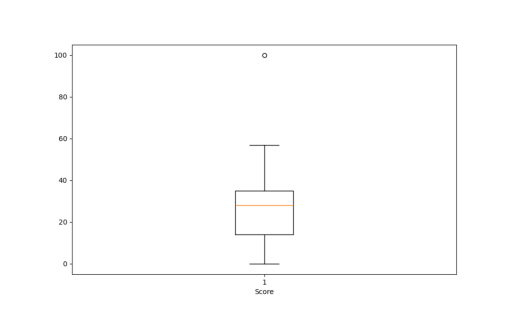

In [21]:
import cv2

plt.imshow(plt.imread(image_box));
plt.axis('off')

In [96]:
validation_1 = '''    BDCABDC ABCDEEB ADEBEEB ABABABA ACBDDBC EABCDEA BBDCBDB ACBACBA BCDABCA ABCDBDD ADBCADE ABCABCA baabada AAAAAAA EABCDEA ADDBBAC ABCDEAC ABCDEBA ABABCDA ABDCABD ABABABA CACACAC ABBACAB ABCDDAB DBBDBAC ABCDBAD ABCDEAD CCCCCCC ABCABDA BDBBBDA EDABCDE ACDEBAC ACDBBDC ABCDBAE BBBBBBB ABCDEAB AEBCDAB CDDBBAD ADDBADD EABCDEA  EEEEEEE ABCDDEA ABCCBAA DCBAABC BCADEAB BDABEEB DEBAEBA '''
validation_1 = validation_1.upper().split(' ')
validation_1 = [word for word in validation_1 if len(word) != 0]

validation_2 = '''
['B', 'D', 'C', 'A', 'B', 'D', 'C']
['A', 'B', 'C', 'D', 'E', 'E', 'B']
['A', 'D', 'E', 'B', 'E', 'E', 'B']
['A', 'B', 'A', 'B', 'A', 'B', 'A']
['A', 'C', 'B', 'D', 'D', 'B', 'C']
['E', 'A', 'B', 'C', 'D', 'E', 'A']
['B', 'B', 'D', 'C', 'B', 'D', 'B']
['A', 'C', 'B', 'A', 'C', 'B', 'A']
['B', 'C', 'D', 'A', 'B', 'C', 'A']
['A', 'B', 'C', 'D', 'B', 'D', 'D']
['A', 'D', 'B', 'C', 'A', 'D', 'E']
['A', 'B', 'C', 'A', 'B', 'C', 'A']
['B', 'A', 'A', 'B', 'A', 'D', 'A']
['A', 'A', 'A', 'A', 'A', 'A', 'A']
['E', 'A', 'B', 'C', 'D', 'E', 'A', '7']
['A', 'D', 'D', 'B', 'B', 'A', 'C']
['A', 'B', 'C', 'D', 'E', 'A', 'C']
['A', 'B', 'C', 'D', 'E', 'B', 'A']
['A', 'B', 'A', 'B', 'C', 'D', 'A']
['A', 'B', 'D', 'C', 'A', 'B', 'D']
['A', 'B', 'A', 'B', 'A', 'B', 'A']
['C', 'A', 'C', 'A', 'C', 'A', 'C']
['A', 'B', 'B', 'A', 'C', 'A', 'B']
['A', 'B', 'C', 'D', 'D', 'A', 'D']
['D', 'B', 'B', 'D', 'B', 'A', 'C']
['A', 'B', 'C', 'D', 'B', 'A', 'D']
['A', 'B', 'C', 'D', 'E', 'A', 'D']
['C', 'C', 'C', 'C', 'C', 'C', 'C']
['A', 'B', 'C', 'A', 'B', 'D', 'A']
['B', 'D', 'B', 'B', 'B', 'D', 'A']
['E', 'D', 'A', 'B', 'C', 'D', 'E']
['A', 'C', 'D', 'E', 'B', 'A', 'C']
['A', 'C', 'D', 'B', 'B', 'D', 'C']
['A', 'D', 'C', 'D', 'B', 'A', 'E']
['B', 'B', 'B', 'B', 'B', 'B', 'B']
['A', 'B', 'C', 'D', 'E', 'A', 'B']
['A', 'E', 'B', 'C', 'D', 'A', 'B']
['C', 'D', 'D', 'B', 'B', 'A', 'D']
['A', 'D', 'D', 'B', 'A', 'D', 'D']
['E', 'A', 'B', 'C', 'D', 'E', 'A']
['E', 'E', 'E', 'E', 'E', 'E', 'E']
['A', 'B', 'C', 'D', 'D', 'E', 'A']
['A', 'B', 'C', 'C', 'B', 'A', 'A']
['D', 'C', 'B', 'A', 'A', 'B', 'C']
['B', 'C', 'A', 'D', 'E', 'A', 'B']
['B', 'D', 'A', 'B', 'E', 'E', 'B']
['D', 'E', 'D', 'A', 'E', 'B', 'A']

'''

validation_2 = validation_2.split('\n')

validation_2 = [word for word in validation_2 if len(word) != 0]
validation_21 = []
for i in validation_2:
    i = i.replace('[', '')
    i = i.replace("'", '')
    i = i.replace(' ', '')

    i = i.split(']')

    
    for j in i:
        if len(j) > 0:
            validation_21.append(j)

validation_2 = []
for i in validation_21:
    counter = ''
    for j in i:
        if j != ' ' and j!=',' and len(counter) <= 7:
            counter+=j
            # print(counter)
    validation_2.append(counter)


counter = 0
if len(validation_1) == len(validation_2):
    for i in range(len(validation_1)):
        if validation_1[i] == validation_2[i]:
            counter += 1

print(counter)



43


In [27]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 


def statics():
    path_f = r'static\uploads\results.xlsx'
    path_f = path_f.replace('\\', '/')
    df = pd.read_excel(io=path_f)
    score_student = df['exam_grade']
    mean_score = score_student.mean()
    median_score = score_student.median()
    std_score = score_student.std()
    var_score = score_student.var()

    plt.figure(figsize=(10,6))
    plt.hist(score_student, bins=10, color='skyblue', edgecolor='black')
    plt.xlabel('Score')
    image_hist= 'hist_plot.png'
    plt.savefig(image_hist)
    plt.close()

    plt.figure(figsize=(10,6))
    plt.boxplot(score_student)
    plt.xlabel('Score')
    image_box= 'box_plot.png'
    plt.savefig(image_box)
    plt.close()


    return mean_score, median_score, std_score, var_score, image_hist, image_box

mean_score, median_score, std_score, var_score, image_hist, image_box = statics()


(-0.5, 999.5, 599.5, -0.5)

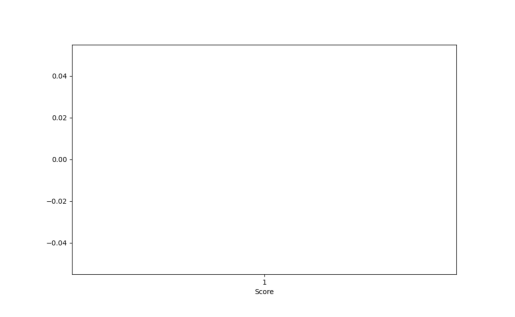

In [29]:
plt.imshow(plt.imread(image_box))
plt.axis('off')

In [ ]:
MM